
### Project Brief

You have been hired as a data scientist at a used car dealership in the UK. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data cleaning and analysis
import pandas as pd
import numpy as np

#data visulization
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

#model selection 
from sklearn.ensemble import RandomForestRegressor

#evalution 
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_val_score

#data split
from sklearn.model_selection import train_test_split

#data encoding
from sklearn.preprocessing import LabelEncoder


plt.style.use('ggplot')

In [ ]:
#reading csv
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/toyota.csv")

EDA

In [ ]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [ ]:
#checking if there is any null value
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [ ]:
#let's see data type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


There is several column with wrong datatype we need to convert it into appropriate datatye

In [ ]:
#basic statistical information
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


In [ ]:
#dataframe shape
df.shape

(6738, 9)

In [ ]:
df.nunique()

model             18
year              23
price           2114
transmission       4
mileage         5699
fuelType           4
tax               29
mpg               81
engineSize        16
dtype: int64

data cleaning

In [ ]:
#change datatype where require
df['model']=df['model'].astype('category')
df['transmission']=df['transmission'].astype('category')
df['fuelType']=df['fuelType'].astype('category')                               
                

In [ ]:
#let's see the frequency of categorical value
px.histogram(df,x='model')

Yaris and Aygo have high number of frequency compare to other model

In [ ]:
px.histogram(df,x='transmission',color='transmission')

Manual transimission has the highest number of frequency

In [ ]:
px.histogram(df,x='fuelType',color='fuelType')

we can see that Petrol has the highest frequency 

Data visulization

In [ ]:
#let's see how price differ with year
year_df=df.groupby('year')['price'].sum()
year_df=year_df.reset_index()

In [ ]:
px.line(year_df,x='year',y='price')

As we can see that there is exponential raise in price from 2012 to around 2019 ,but there is sudden breakdown in 2020

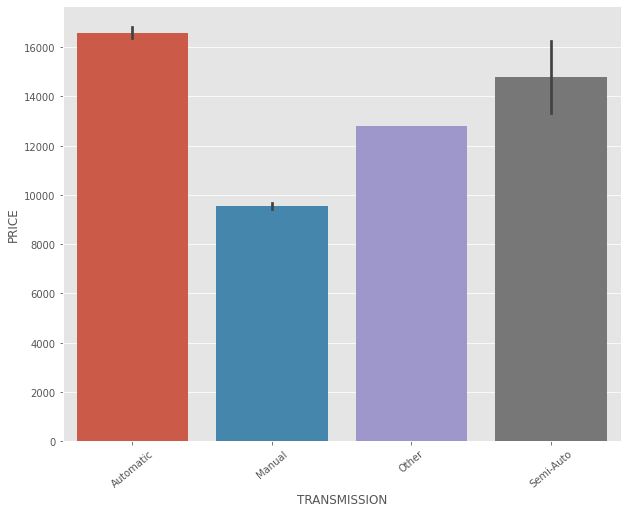

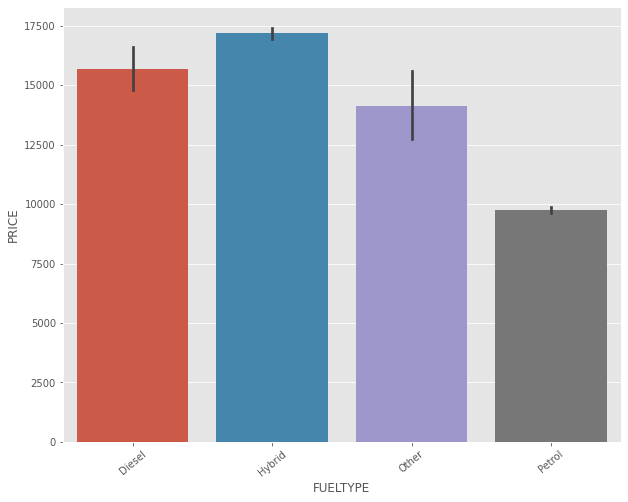

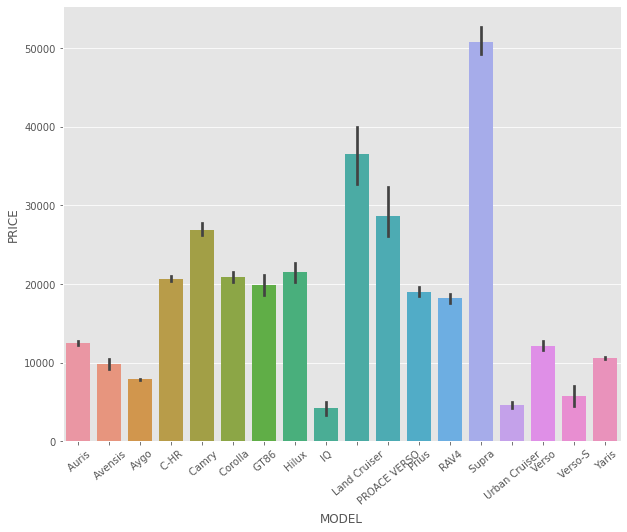

In [ ]:

cat=['transmission','fuelType','model']

for i in cat:
    plt.figure(figsize=(10,8))

    sns.barplot(x=i,y='price',data=df)
    
    plt.xlabel(i.upper())
    
    plt.ylabel("PRICE")
    
    plt.xticks(rotation=40)
    
    plt.show()
    
    print("\n\n")

1) From Price V/s transmission barplot we can conclude that automic car has the highest number price

2) From Price V/s Fueltype barplot we can conclude that Hybrid has the highest number of price


3) From Price V/s model barplot we can conclude that Supra model is costlier than other model


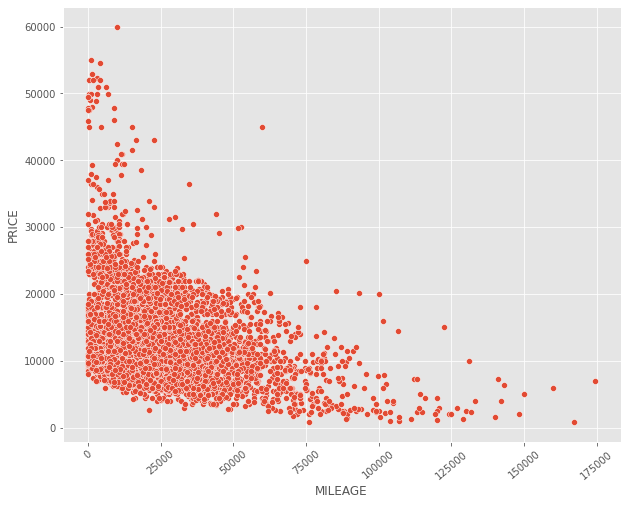

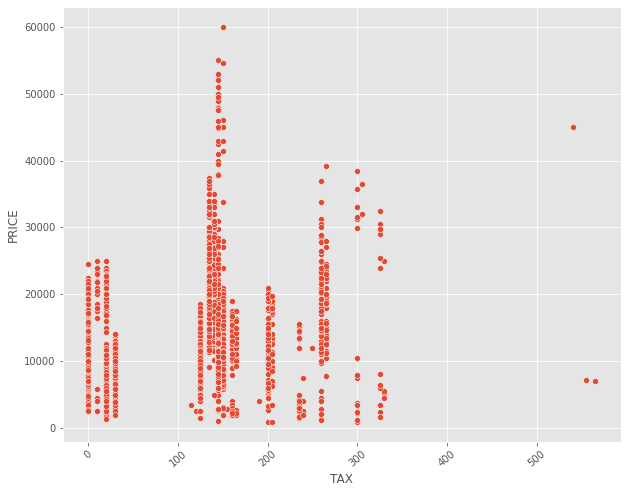

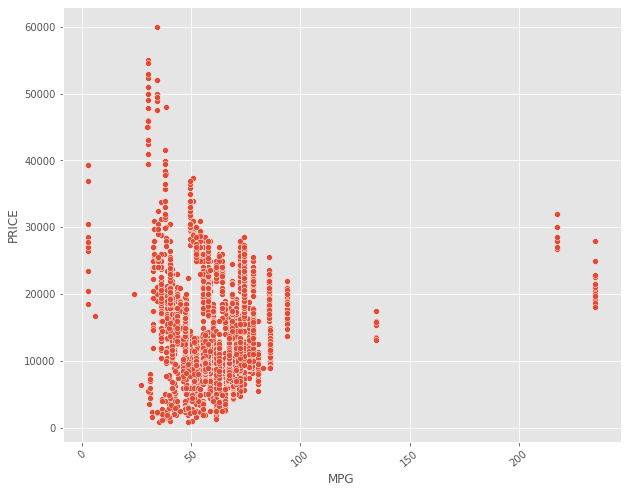

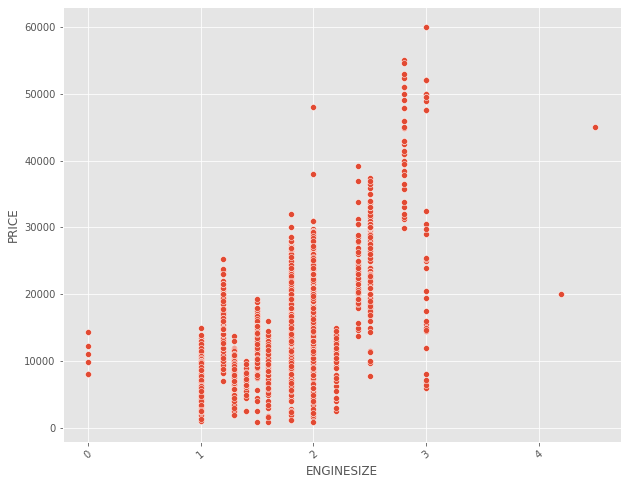

In [ ]:
con=['mileage','tax','mpg','engineSize']

for i in con:
    plt.figure(figsize=(10,8))

    sns.scatterplot(x=i,y='price',data=df)
    
    plt.xlabel(i.upper())
    
    plt.ylabel("PRICE")
    
    plt.xticks(rotation=40)
    
    plt.show()
    
    print("\n\n")

1) From Price V/s mileage graph we can conclude that as the mileage increase,price decrease with it(small amount of change).

2) From Price V/s mileage graph we can conclude that where tax is between 100 to 200 ,price of car is high compare to other value of tax.

3) Price V/s Enginsize graph is shows obvious result that Engine size is proposional to price 

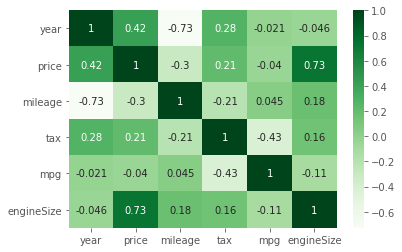

In [ ]:
#Now let's how features are relating to dependent variable
sns.heatmap(df.corr(),annot=True, cmap='Greens')

we can see that year has high amount of relation compare to other features

In [ ]:
#let's see price thresold value
px.box(df,y='price')

Price thresold value is around 26k.Price have several outlier.

MODEL FITTING

In [ ]:
#EXTRACT dependent and independent features for prediction
X=df.drop(['price'],axis=1)
y=df['price']

In [ ]:
# machine learning models only work with numeric data so we have to encode the data
le=LabelEncoder()
X[X.select_dtypes(include=['category']).columns] = X[X.select_dtypes(include=['category']).columns].apply(le.fit_transform)

In [ ]:
#let's split the data for model traning and validation

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

We'll use randomforestregressor for our model training.
you might have question why we should use randomforest for this process,and the only reason is random forest is bagging algorithm and it is use Dicision tree as base model.


In [ ]:
rf=RandomForestRegressor(n_estimators=500,max_depth= 15,
               min_samples_split= 5,
               min_samples_leaf=2,
               bootstrap= True)

In [ ]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred=rf.predict(X_test)

In [ ]:
#let's compare value just for reference
pd.DataFrame({"True":y_test,"Pred":y_pred})

,True,Pred
381,37440,34629.454811
2476,4159,3992.444717
2855,10600,11370.308205
2018,8995,10103.907070
2185,11000,9849.680740
...,...,...
4715,10800,9744.071903
5374,7495,7451.831428
1027,10790,10362.484401
2802,9991,9096.029291


Model evalution

In [ ]:
print("Model accuracy is" ,round(rf.score(X_test,y_test),2))

Model accuracy is 0.97


In [ ]:
print("R-square of model is",round(r2_score(y_pred,y_test),2))

R-square of model is 0.97


R-square values shows that how good our model is fitted.

In [ ]:
print("Root Mean squared error is",round(np.sqrt(mean_squared_error(y_test, y_pred))))

Root Mean squared error is 1210


Conclusion:-

1) there several parameter like transmission,model and fuelType are affecting price of car.

2) we can control over some parameter and lessen down car price 

